In [57]:
import pandas as py
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
%cd drive
!ls
%cd MyDrive
!ls
%cd Mlba1
!ls
%cd D5-14
!ls

[Errno 2] No such file or directory: 'drive'
/content/drive/MyDrive/Mlba1/D5-14
ADB				    average_pupil_by_condition.csv
ADB_average_pupil_by_condition.csv  AYP
AMR				    KHI
AMR_average_pupil_by_condition.csv  KHI_average_pupil_by_condition.csv
ANT				    merged_all_data.csv
ARV				    merged_cued_data.csv
ARV_average_pupil_by_condition.csv  merged_uncued_data.csv
ASL				    SRM
ASL_average_pupil_by_condition.csv  SRM_average_pupil_by_condition.csv
ASR				    TUS
ASR_average_pupil_by_condition.csv  TUS_average_pupil_by_condition.csv
[Errno 2] No such file or directory: 'MyDrive'
/content/drive/MyDrive/Mlba1/D5-14
ADB				    average_pupil_by_condition.csv
ADB_average_pupil_by_condition.csv  AYP
AMR				    KHI
AMR_average_pupil_by_condition.csv  KHI_average_pupil_by_condition.csv
ANT				    merged_all_data.csv
ARV				    merged_cued_data.csv
ARV_average_pupil_by_condition.csv  merged_uncued_data.csv
ASL				    SRM
ASL_average_pupil_by_condition.csv  SRM_average_pupil_by_condition.csv


In [63]:
from google.colab import drive
drive.mount('/content/drive')
import os, pandas as pd, numpy as np
base_path = '/content/drive/MyDrive/Mlba1/D5-14'
os.chdir(base_path)
participants = ['ADB','AMR','ANT','ARV','ASL','ASR','AYP','KHI','SRM','TUS']
blocks = ['E1', 'E2', 'E3']        # E1 = Happy, E2 = Angry, E3 = Neutral
subfolders = ['1', '2']
file_names = ['target_cued.csv','target_uncued.csv']
cued_list = []
uncued_list = []
for participant in participants:
    for block in blocks:
        for subfolder in subfolders:
            subfolder_path = os.path.join(base_path, participant, block, subfolder)
            cued_file = os.path.join(subfolder_path, 'target_cued.csv')
            uncued_file = os.path.join(subfolder_path, 'target_uncued.csv')
            if os.path.exists(cued_file):
                df_cued = pd.read_csv(cued_file, engine='python')
                df_cued['participant'] = participant
                df_cued['block'] = block
                df_cued['subfolder'] = subfolder
                df_cued['cue_validity'] = 'valid'
                cued_list.append(df_cued)

            if os.path.exists(uncued_file):
                df_uncued = pd.read_csv(uncued_file, engine='python')
                df_uncued['participant'] = participant
                df_uncued['block'] = block
                df_uncued['subfolder'] = subfolder
                df_uncued['cue_validity'] = 'invalid'
                uncued_list.append(df_uncued)
cued_df = pd.concat(cued_list, ignore_index=True, sort=False)
if len(uncued_list) > 0:
    uncued_df = pd.concat(uncued_list, ignore_index=True, sort=False)
else:
    print("Warning: No uncued files found.")
    uncued_df = pd.DataFrame()
print("Cued DataFrame shape:", cued_df.shape)
print("Uncued DataFrame shape:", uncued_df.shape)
all_df = pd.concat([cued_df, uncued_df], ignore_index=True)
print("Combined DataFrame shape:", all_df.shape)
meta_cols = ["participant","block","emotion","subfolder","cue_validity","image_name","response_key","response_time","location","cue_location","eccentricity","response_time_ms"]
def get_time_cols(df):
    return sorted([col for col in df.columns if col.startswith("t")],key=lambda x: int(x[1:]) if x[1:].isdigit() else x)
timecued = set(get_time_cols(cued_df))
time_cols_uncued = set(get_time_cols(uncued_df))
all_time_cols = sorted(list(timecued.union(time_cols_uncued)),key=lambda x: int(x[1:]) if x[1:].isdigit() else x)
ordered_cols = meta_cols + all_time_cols
cued_df = cued_df.reindex(columns=ordered_cols)
uncued_df = uncued_df.reindex(columns=ordered_cols)
print("Cued DataFrame columns after merging :", ordered_cols[:15], "...", ordered_cols[-5:])
print("Uncued DataFrame columns after merging : ", ordered_cols[:15], "...", ordered_cols[-5:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cued DataFrame shape: (1689, 478)
Uncued DataFrame shape: (381, 478)
Combined DataFrame shape: (2070, 478)
Cued DataFrame columns after merging : ['participant', 'block', 'emotion', 'subfolder', 'cue_validity', 'image_name', 'response_key', 'response_time', 'location', 'cue_location', 'eccentricity', 'response_time_ms', 't1', 't2', 't3'] ... ['t465', 't466', 't467', 't468', 't469']
Uncued DataFrame columns after merging :  ['participant', 'block', 'emotion', 'subfolder', 'cue_validity', 'image_name', 'response_key', 'response_time', 'location', 'cue_location', 'eccentricity', 'response_time_ms', 't1', 't2', 't3'] ... ['t465', 't466', 't467', 't468', 't469']


Saved average pupil time-series CSV with shape: (12, 386)


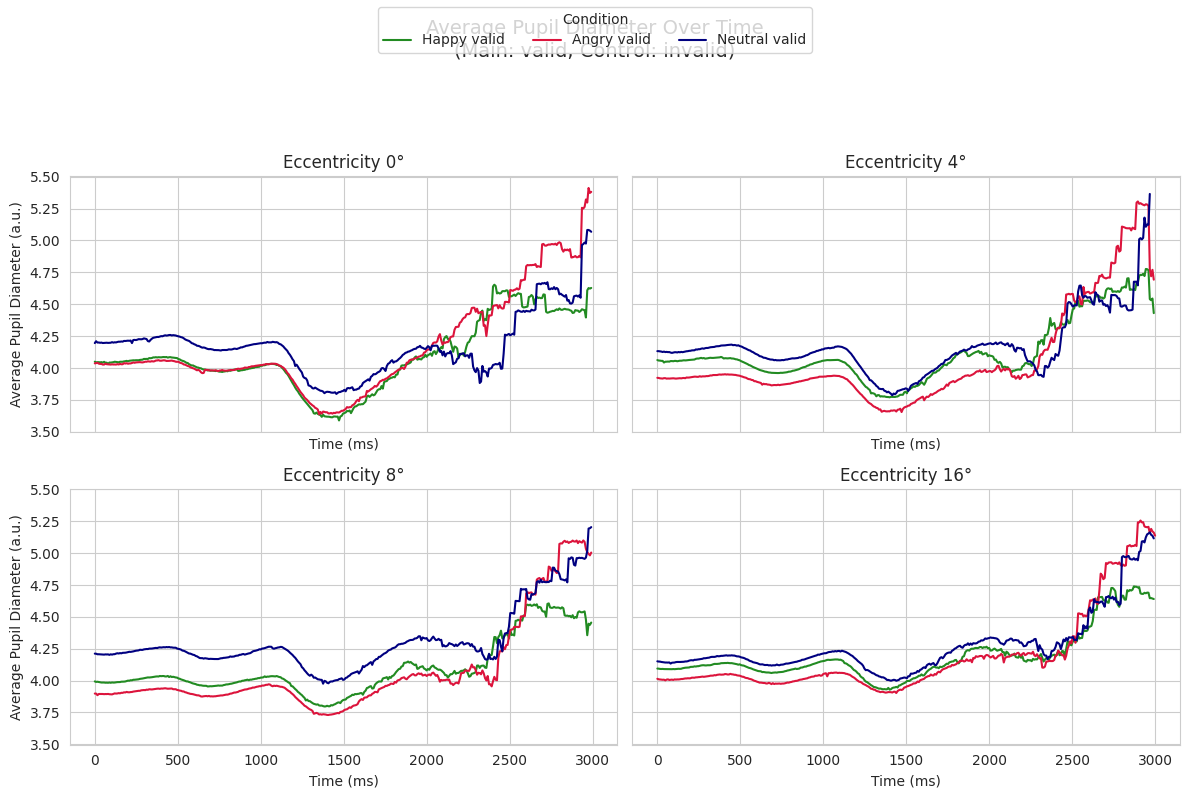

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def prepare_data(df, emotion_map={'E1': 'Happy', 'E2': 'Angry', 'E3': 'Neutral'},pupil_time_prefix='t', ref_time='t87'):
    if 'emotion' not in df.columns:
        if 'block' in df.columns:
            df['emotion'] = df['block'].map(emotion_map)
        else:
            raise KeyError("df must contain either 'emotion' or 'block'.")
    if 'validity' not in df.columns:
        if 'cue_validity' in df.columns:
            df['validity'] = df['cue_validity']
        else:
            df['validity'] = 'valid'
    if 'eccentricity' not in df.columns:
        if 'location' in df.columns:
            df['eccentricity'] = df['location'].abs()
        else:
            raise KeyError("df must contain either 'eccentricity' or 'location'.")
    pupil_timepoints = [col for col in df.columns if col.startswith(pupil_time_prefix)]
    if ref_time not in pupil_timepoints:
        raise KeyError(f"Column '{ref_time}' not found in df.")
    start_idx = pupil_timepoints.index(ref_time)
    pupil_cols_post = pupil_timepoints[start_idx:]
    return df, pupil_cols_post
def compute_avg_pupil(df, pupil_cols):
    df_avg = df.groupby(['emotion', 'validity', 'eccentricity'])[pupil_cols].mean().reset_index()
    df_avg['eccentricity'] = df_avg['eccentricity'].astype(int)
    return df_avg
def save_avg_pupil(df_avg, filename="average_pupil_by_condition.csv"):
    df_avg.to_csv(filename, index=False)
    print("Saved average pupil time-series CSV with shape:", df_avg.shape)
def plot_avg_pupil(df_avg, pupil_cols, color_map, emotions, validities, time_multiplier=8):
    ecc_values = sorted(df_avg['eccentricity'].unique())
    n_subplots = len(ecc_values)
    n_cols = 2
    n_rows = int(np.ceil(n_subplots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    time_points = np.arange(len(pupil_cols)) * time_multiplier
    for i, (ax, ecc) in enumerate(zip(axes, ecc_values)):
        subset = df_avg[df_avg['eccentricity'] == ecc]
        for emotion in emotions:
            for val in validities:
                cond_data = subset[(subset['emotion'] == emotion) &
                                   (subset['validity'].str.lower() == val)]
                if cond_data.empty:
                    continue
                avg_trace = cond_data[pupil_cols].values.flatten()
                linestyle = '-' if val == 'valid' else '--'
                ax.plot(time_points, avg_trace, linestyle=linestyle, color=color_map[emotion],
                        label=f"{emotion} {val}")
        ax.set_title(f"Eccentricity {int(ecc)}°")
        ax.set_xlabel("Time (ms)")
        if i % n_cols == 0:
            ax.set_ylabel("Average Pupil Diameter (a.u.)")
        ax.grid(True)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, title="Condition")
    fig.suptitle("Average Pupil Diameter Over Time\n(Main: valid, Control: invalid)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()
df_all, pupil_cols_post = prepare_data(df_all)
df_avg_pupil = compute_avg_pupil(df_all, pupil_cols_post)
save_avg_pupil(df_avg_pupil)
color_map = {'Happy': 'forestgreen', 'Angry': 'crimson', 'Neutral': 'navy'}
emotions = ['Happy', 'Angry', 'Neutral']
validities = ['valid', 'invalid']
plot_avg_pupil(df_avg_pupil, pupil_cols_post, color_map, emotions, validities)

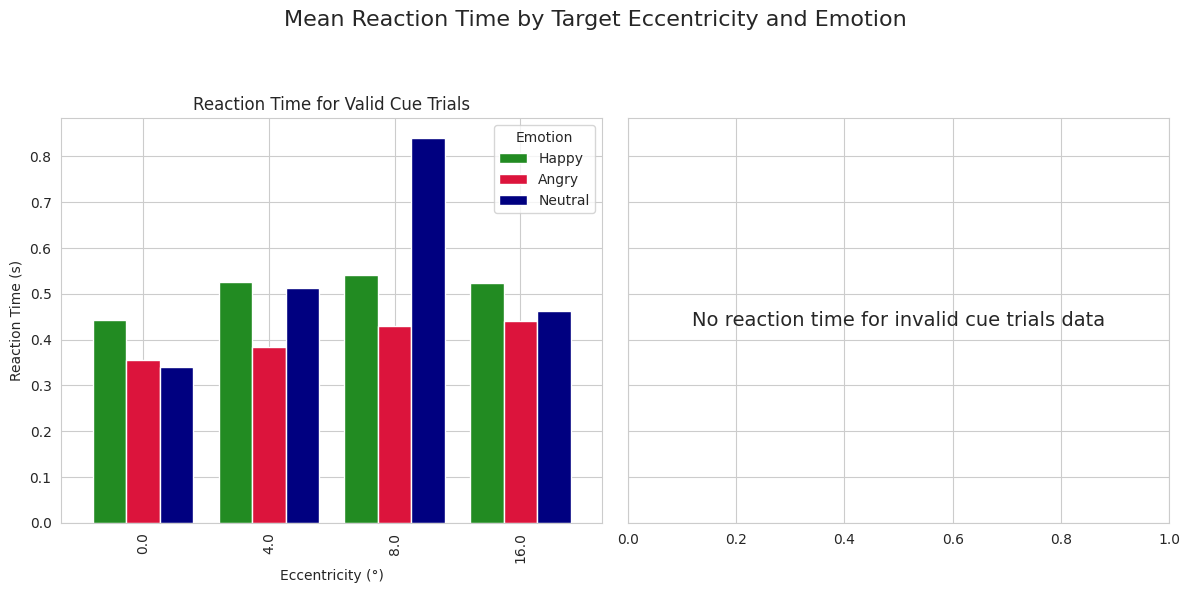

In [64]:
import matplotlib.pyplot as plt
def preprocess_validity(df):
    df['validity'] = df['validity'].str.lower()
    return df
def compute_mean_response_time(df, validity_value):
    df_filtered = df[df['validity'] == validity_value]
    if df_filtered.empty:
        return None
    return df_filtered.groupby(['eccentricity', 'emotion'])['response_time'].mean().unstack('emotion')
def plot_response_time(ax, mean_rt, title, emotion_order, color_map):
    if mean_rt is not None and not mean_rt.empty:
        mean_rt = mean_rt.reindex(columns=emotion_order)
        mean_rt.plot(kind='bar', ax=ax, color=[color_map[e] for e in emotion_order], width=0.8)
        ax.set_title(title)
        ax.set_xlabel("Eccentricity (°)")
        ax.set_ylabel("Reaction Time (s)")
        ax.legend(title="Emotion", loc='upper right')
    else:
        ax.text(0.5, 0.5, f"No {title.lower()} data", transform=ax.transAxes,ha='center', va='center', fontsize=14)
emotion_order = ['Happy', 'Angry', 'Neutral']
color_map = {'Happy': 'forestgreen', 'Angry': 'crimson', 'Neutral': 'navy'}
df_all = preprocess_validity(df_all)
mean_rt_valid = compute_mean_response_time(df_all, 'valid')
mean_rt_invalid = compute_mean_response_time(df_all, 'invalid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plot_response_time(ax1, mean_rt_valid, "Reaction Time for Valid Cue Trials", emotion_order, color_map)
plot_response_time(ax2, mean_rt_invalid, "Reaction Time for Invalid Cue Trials", emotion_order, color_map)
fig.suptitle("Mean Reaction Time by Target Eccentricity and Emotion", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


# Reaction Time vs. Average Pupil Diameter

Correlation (all trials): 0.048 | Valid: 0.048 | Invalid: nan


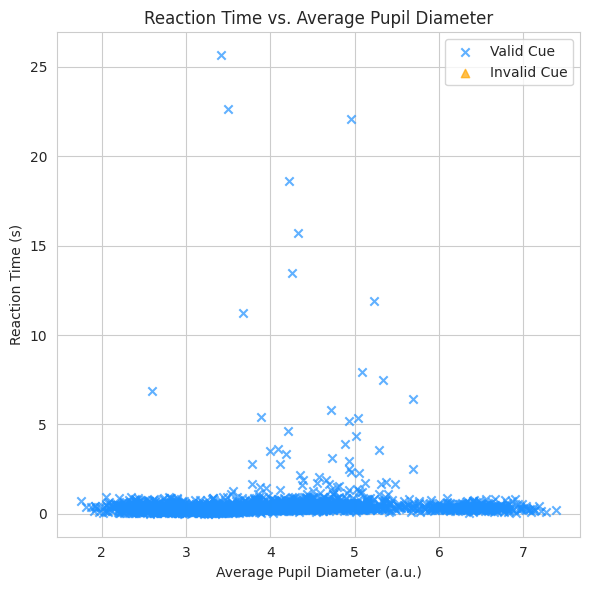

In [65]:
import matplotlib.pyplot as plt
def add_pupil_mean(df, pupil_columns):
    df['pupil_mean'] = df[pupil_columns].mean(axis=1)
    return df
def calculate_correlations(df):
    corr_all = df['pupil_mean'].corr(df['response_time'])
    valid_df = df[df['validity'].str.lower() == 'valid']
    invalid_df = df[df['validity'].str.lower() == 'invalid']
    corr_valid = valid_df['pupil_mean'].corr(valid_df['response_time'])
    corr_invalid = invalid_df['pupil_mean'].corr(invalid_df['response_time'])
    return corr_all, corr_valid, corr_invalid
def plot_response_scatter(df):
    fig, ax = plt.subplots(figsize=(6, 6))
    valid_trials = df[df['validity'].str.lower() == 'valid']
    invalid_trials = df[df['validity'].str.lower() == 'invalid']
    ax.scatter(valid_trials['pupil_mean'], valid_trials['response_time'],c='dodgerblue', marker='x', label='Valid Cue', alpha=0.7)
    ax.scatter(invalid_trials['pupil_mean'], invalid_trials['response_time'],c='orange', marker='^', label='Invalid Cue', alpha=0.7)
    ax.set_xlabel("Average Pupil Diameter (a.u.)")
    ax.set_ylabel("Reaction Time (s)")
    ax.set_title("Reaction Time vs. Average Pupil Diameter")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
df_all = add_pupil_mean(df_all, pupil_cols_post)
corr_all, corr_valid, corr_invalid = calculate_correlations(df_all)
print(f"Correlation (all trials): {corr_all:.3f} | Valid: {corr_valid:.3f} | Invalid: {corr_invalid:.3f}")
plot_response_scatter(df_all)